In [1]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

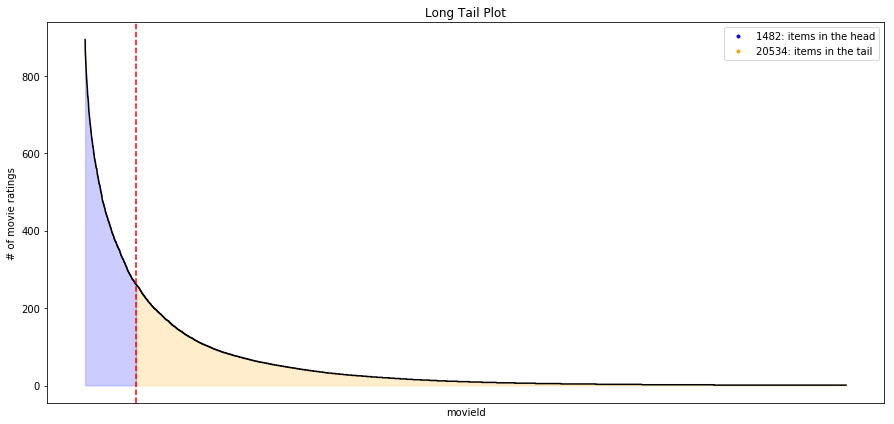

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

## test/train split

In [7]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[1025, 2561, 5131, 12, 1603, 1043, 4641, 1061,..."
208,"[3083, 2065, 3096, 3101, 34, 1060, 3114, 7219,..."
359,"[2560, 1281, 6664, 34319, 1552, 2580, 539, 824..."
394,"[6666, 2571, 529, 3090, 2094, 1073, 58, 6721, ..."
572,"[47124, 55830, 4121, 59418, 3101, 31, 43556, 1..."


In [8]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [9]:
#make recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
156,"[1025, 2561, 5131, 12, 1603, 1043, 4641, 1061,...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ..."
208,"[3083, 2065, 3096, 3101, 34, 1060, 3114, 7219,...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ..."
359,"[2560, 1281, 6664, 34319, 1552, 2580, 539, 824...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ..."
394,"[6666, 2571, 529, 3090, 2094, 1073, 58, 6721, ...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ..."
572,"[47124, 55830, 4121, 59418, 3101, 31, 43556, 1...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ..."


In [10]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [11]:
#make recommendations for all members in the test data

recs = []
for user in test.index.tolist():
    random_predictions = train_long.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions
userId,,,
156,"[1025, 2561, 5131, 12, 1603, 1043, 4641, 1061,...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[2921, 3439, 3254, 714, 2124, 33794, 595, 2541..."
208,"[3083, 2065, 3096, 3101, 34, 1060, 3114, 7219,...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[8585, 106992, 1921, 26242, 1927, 1334, 6093, ..."
359,"[2560, 1281, 6664, 34319, 1552, 2580, 539, 824...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[3138, 2739, 1393, 3074, 158, 90947, 3545, 357..."
394,"[6666, 2571, 529, 3090, 2094, 1073, 58, 6721, ...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[55269, 2470, 2020, 69481, 3529, 1354, 553, 73..."
572,"[47124, 55830, 4121, 59418, 3101, 31, 43556, 1...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[8261, 736, 2580, 8330, 3546, 1685, 36525, 597..."


In [12]:
random_predictions = test.random_predictions.values.tolist()

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [13]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131176,131231,131239,131241,131243,131248,131250,131252,131254,131256
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,0.0,3.0,3.0,4.0,4.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [15]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131176,131231,131239,131241,131243,131248,131250,131252,131254,131256
156,3.208132,5.035874,1.468654,2.315571,1.551280,3.878343,3.183399,0.867369,1.607434,3.107057,...,-0.036042,-0.036024,0.009579,0.009579,0.009579,0.009579,0.009579,0.009579,0.009579,0.009579
208,3.293959,-0.136676,0.142910,0.511741,-0.162068,1.541292,0.372567,-0.155259,0.291103,0.242496,...,0.024059,0.007603,-0.021581,-0.021581,-0.021581,-0.021581,-0.021581,-0.021581,-0.021581,-0.021581
359,3.944746,1.652088,0.474845,-0.233990,0.657829,3.987834,1.632840,-0.062786,0.391381,2.430455,...,-0.034974,-0.014073,-0.019866,-0.019866,-0.019866,-0.019866,-0.019866,-0.019866,-0.019866,-0.019866
394,2.725251,0.454404,0.073134,-0.166303,0.388909,2.018065,-0.061377,-0.359734,0.317420,1.340121,...,-0.053533,-0.040220,-0.020339,-0.020339,-0.020339,-0.020339,-0.020339,-0.020339,-0.020339,-0.020339
572,3.846007,2.400244,2.148188,-0.117901,2.072837,1.210946,0.211777,0.321039,0.146300,1.589498,...,0.034281,-0.040158,0.007488,0.007488,0.007488,0.007488,0.007488,0.007488,0.007488,0.007488


In [16]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [17]:
get_users_predictions(156, 10, cf_model, train_long)

[3361, 3702, 3708, 4280, 1603, 1721, 4448, 1291, 151, 1678]

In [18]:
#make recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions,cf_predictions
userId,,,,
156,"[1025, 2561, 5131, 12, 1603, 1043, 4641, 1061,...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[2921, 3439, 3254, 714, 2124, 33794, 595, 2541...","[3361, 3702, 3708, 4280, 1603, 1721, 4448, 129..."
208,"[3083, 2065, 3096, 3101, 34, 1060, 3114, 7219,...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[8585, 106992, 1921, 26242, 1927, 1334, 6093, ...","[8949, 1077, 1288, 2289, 1247, 34, 515, 4226, ..."
359,"[2560, 1281, 6664, 34319, 1552, 2580, 539, 824...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[3138, 2739, 1393, 3074, 158, 90947, 3545, 357...","[34319, 648, 318, 44199, 34048, 1653, 36529, 2..."
394,"[6666, 2571, 529, 3090, 2094, 1073, 58, 6721, ...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[55269, 2470, 2020, 69481, 3529, 1354, 553, 73...","[5013, 903, 2300, 1225, 2174, 6440, 1649, 2716..."
572,"[47124, 55830, 4121, 59418, 3101, 31, 43556, 1...","[593, 1198, 2762, 318, 1270, 608, 2571, 1240, ...","[8261, 736, 2580, 8330, 3546, 1685, 36525, 597...","[1265, 48780, 8781, 6281, 30825, 48516, 45672,..."


In [19]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [20]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0006538049303322615,
 0.0011093247588424438,
 0.0013987138263665594,
 0.0016237942122186496,
 0.0018595927116827437,
 0.002000714540907467,
 0.002172204358699536,
 0.0023035012504465883,
 0.0024214005001786353,
 0.002536084315827081]

In [21]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0003644158628081457,
 0.00047695605573419087,
 0.0005698463737048947,
 0.0006261164701679172,
 0.0006689889246159342,
 0.0007047159699892819,
 0.00076443117439902,
 0.0008113229214515388,
 0.0008482408683373312,
 0.0008878978887017473]

In [23]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.00795284030010718,
 0.014790996784565916,
 0.020878885316184353,
 0.026487138263665593,
 0.03171972132904609,
 0.03671078956770275,
 0.04134867044352575,
 0.045826162404940536,
 0.049955017948587074,
 0.053804964358019014]

# Mark Plot

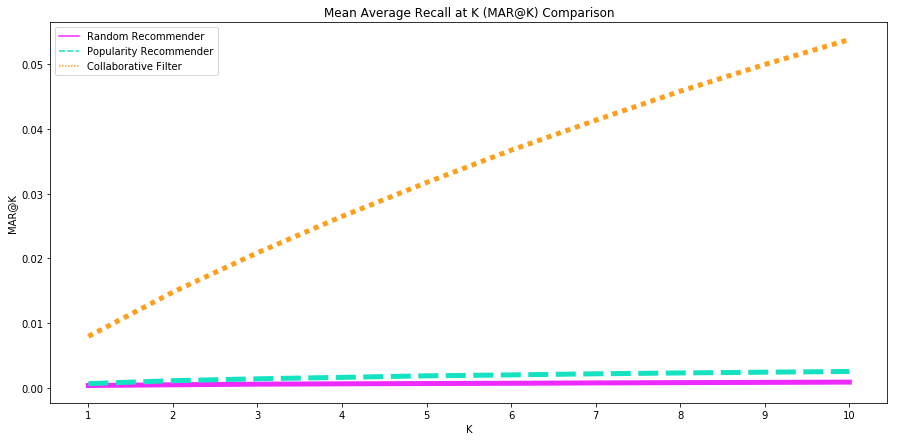

In [24]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [25]:
catalog = train_long.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

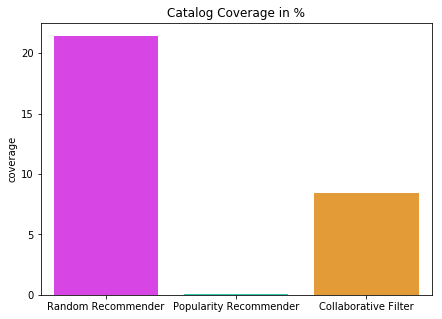

In [26]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.CoveragePlot(coverage_scores, model_names)

# Personalization

In [27]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [28]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [29]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [31]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [32]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773